# Esercizio 4: Molecular Dynamics

Simulo un sistema di Argon attraverso un modello di Lennard-Jones ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle seguenti condizioni:
1. fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

Per farlo uso un algoritmo di dinamica molecolare: L'algoritmo di Verlet

Questo algoritmo integra le equazioni del moto attraverso un'espansione di Taylor al terz'ordine a partire da una configurazione iniziale.
$$
r(t+\delta t)=r(t)+\delta t v(t)+\frac{1}{2}\delta t^2 a(t)+\frac{1}{6}\delta t^3 \dot{a}(t)+o(t^4) \\
r(t-\delta t)=r(t)-\delta t v(t)+\frac{1}{2}\delta t^2 a(t)-\frac{1}{6}\delta t^3 \dot{a}(t)+o(t^4)
$$

Sommandole si ottiene la nuova posizione ad un passo discreto $t+\delta t$
$$
r(t+\delta t)\simeq r(t)-r(t-\delta t)+\delta t^2 a(t)
$$

Inizialmente, per integrare le equazioni del moto,  è quindi necessario generare delle posizioni $r(t-\delta t)$. Questo viene fatto generando delle velocità tridimensionali casuali uniformemente distribuite in $[-1,1]$ (per ogni direzione) ed opportunamente riscalate in modo da far coincidere la temperatura del sistema con quella desiderata $T^*$. Questo è possibile grazie al legame tra l'energia cinetica totale e la temperatura
$$
E_k=\sum_{i=1}^N \frac{m v_i^2}{2}=\frac{3}{2}Nk_BT,
$$
moltiplicando le velocità per il fattore di scala $f_s=\sqrt{\frac{T^*}{T}}$ si ottiene una distribuzione di velocità associata alla temperatura $T^*$.

A questo punto viene aggiunta nel codice la possibilità di salvare in un file esterno le posizioni finali al tempo $t$ e $t-\delta t$ in modo da poter ripartire dall'ultima configurazione avendo già le posizioni $r(t-\delta t)$ , mantenendo però la possibilità di modificare le volecità per far combaciare la temperatura del sistema con la temperatura $T^*$, che a questo punto risultano essere seplicemente
$$v(t)\simeq \frac{r(t)-r(t-\delta t)}{\delta t}.$$

In una prima fase viene fatto termalizzare il sistema attraverso una serie di $n_{cicles}$ cicli di $n_{step}$ passi riscalando le velocità all'inizio di ogni ciclo e successivamente calcolando, usando la statistica a blocchi, media e incertezza delle quantità
- $E_p$ Energia potenziale 
- $E_k$ Energia cinetica 
- $E_{tot}$ Energia totale 
- $T$ Temperatura 
- $P$ Pressione


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.optimize as opt

In [4]:
#scalings for reduced units

sigma=0.34          #unit of lenght [nm]
k_b=1.308649E-23    #boltmann const
epsi=k_b*120        #unit of energi [epsilon/k_b=Kelvin]
amu=1.66054E-27     #atomic unit mass [kg]
m=39.948            #unit of mass [amu]

In [24]:
def plots(cartella, Temp):
    N_block=100
    Ek=3/2*Temp*k_b
    file=open(cartella+'ave_epot.out')
    x_epot,epot,err_epot=np.loadtxt(file, delimiter=",", usecols=[0,1,2], unpack=True)

    file=open(cartella+'ave_ekin.out')
    x_ekin,ekin,err_ekin=np.loadtxt(file, delimiter=",", usecols=[0,1,2], unpack=True)

    file=open(cartella+'ave_etot.out')
    x_etot,etot,err_etot=np.loadtxt(file, delimiter=",", usecols=[0,1,2], unpack=True)

    file=open(cartella+'ave_temp.out')
    x_temp,temp,err_temp=np.loadtxt(file, delimiter=",", usecols=[0,1,2], unpack=True)#*(epsi/k_b)
    
    file=open(cartella+'ave_pressure.out')
    x_pres,pres,err_pres=np.loadtxt(file, delimiter=",", usecols=[0,1,2], unpack=True)#*(epsi/k_b)
    
    
    
    temp*=(epsi/k_b)
    err_temp*=(epsi/k_b)
    etot*=epsi
    err_etot*=epsi
    ekin*=epsi
    err_ekin*=epsi
    epot*=epsi
    err_epot*=epsi
    
    pres*=epsi/(sigma**3)
    err_pres*=epsi/(sigma**3)

    #x_temp/=(epsi/k_b)

    #GRAFICI 

    fig,ax=plt.subplots(3,2,figsize=(18,16))
    fig.suptitle('Media a blocchi',  fontsize=18, fontweight='bold')    
    ax[0][0].errorbar(x_epot/(np.max(x_epot)/N_block),epot,yerr=err_epot,label=r'$E_p$')
    ax[0][0].legend()
    ax[0][0].set_xlabel('#block')
    ax[0][0].set_ylabel(f'$E_p/N \quad [J]$')
    ax[0][0].set_title('Energia potenziale')
    ax[0][0].grid(True)

    ax[0][1].errorbar(x_ekin/(np.max(x_ekin)/N_block),ekin,yerr=err_ekin,label=r'$E_k$')
    ax[0][1].set_xlabel('#block')
    ax[0][1].set_ylabel(f'$E_k/N \quad [J]$')
    ax[0][1].set_title('Energia cinetica ')
    ax[0][1].axhline(Ek,color='red', label=r'$E_k^*$')
    ax[0][1].legend()
    ax[0][1].grid(True)

    ax[1][0].errorbar(x_etot/(np.max(x_etot)/N_block),etot,yerr=err_etot,label=r'$E_{tot}$')
    ax[1][0].legend()
    ax[1][0].set_xlabel('#block')
    ax[1][0].set_ylabel(r'$E_{tot}/N  \quad [J]$')
    ax[1][0].set_title('Energia totale')
    ax[1][0].grid(True)

    ax[1][1].errorbar(x_temp/(np.max(x_temp)/N_block),temp,yerr=err_temp,label=r'$T$')
    ax[1][1].set_xlabel('#block')
    ax[1][1].set_ylabel(f'$T \quad [K]$')
    ax[1][1].set_title('Temperatura')
    ax[1][1].axhline(Temp,color='red', label=r'$T^*$')
    ax[1][1].grid(True)
    ax[1][1].legend()
    
    ax[2][0].errorbar(x_pres/(np.max(x_pres)/N_block),pres,yerr=err_pres,label=r'$P$')
    ax[2][0].set_xlabel('#block')
    ax[2][0].set_ylabel(f'$P \quad [Pa]$')
    ax[2][0].set_title('Pressione')
    ax[2][0].grid(True)
    ax[2][0].legend()
    
    ax[2][1].errorbar(x_ekin/(np.max(x_ekin)/N_block),ekin,yerr=err_ekin,label=r'$E_k$')
    ax[2][1].errorbar(x_epot/(np.max(x_epot)/N_block),epot,yerr=err_epot,label=r'$E_p$')
    ax[2][1].errorbar(x_etot/(np.max(x_etot)/N_block),etot,yerr=err_etot,label=r'$E_{tot}$')
    ax[2][1].set_xlabel('#block')
    ax[2][1].set_ylabel(f'$E/N\quad [J]$')
    ax[2][1].set_title('Energie')
    ax[2][1].grid(True)
    ax[2][1].legend()
    plt.show()

---------------

# Argon solido

$T^*=96 K$

Termalizzazione:
- numero di cicli $n_{cicles}=9$
- numero di step per ciclo $n_{step}=200$
- passo temporale $\delta t=0.0005$

Statistica a blocchi:
- numero di blocchi $N_{blocks}=100$
- numero di step per blocco $L=100$

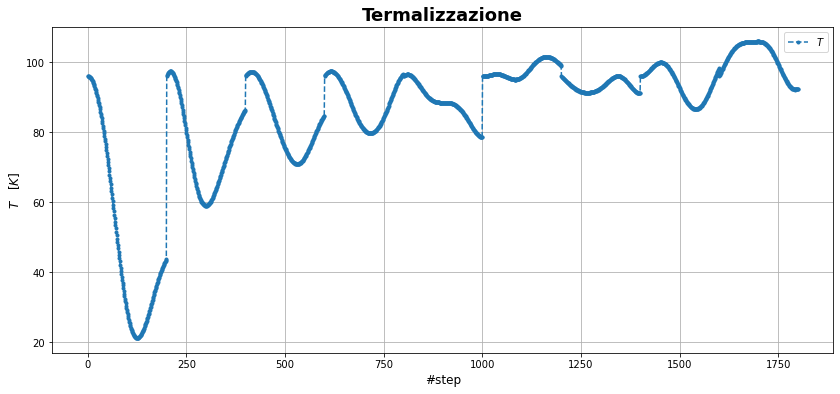

In [26]:
Temp=0.8*(epsi/k_b)

file=open('solid/output_temp.dat')
T=np.loadtxt(file, delimiter=",", usecols=[0], unpack=True)*(epsi/k_b)
x=np.linspace(0,len(T), len(T))
plt.figure(figsize=(14,6))
plt.title("Termalizzazione", fontsize=18, fontweight='bold')
plt.plot(x, T, '.--', label=r'$T$')
plt.ylabel(f'$T \quad [K]$', fontsize=12)
plt.xlabel('#step', fontsize=12)
plt.legend()
plt.grid(True)


Si osserva come il sistema ha termalizzato alla temperatura $T^*=96 K$

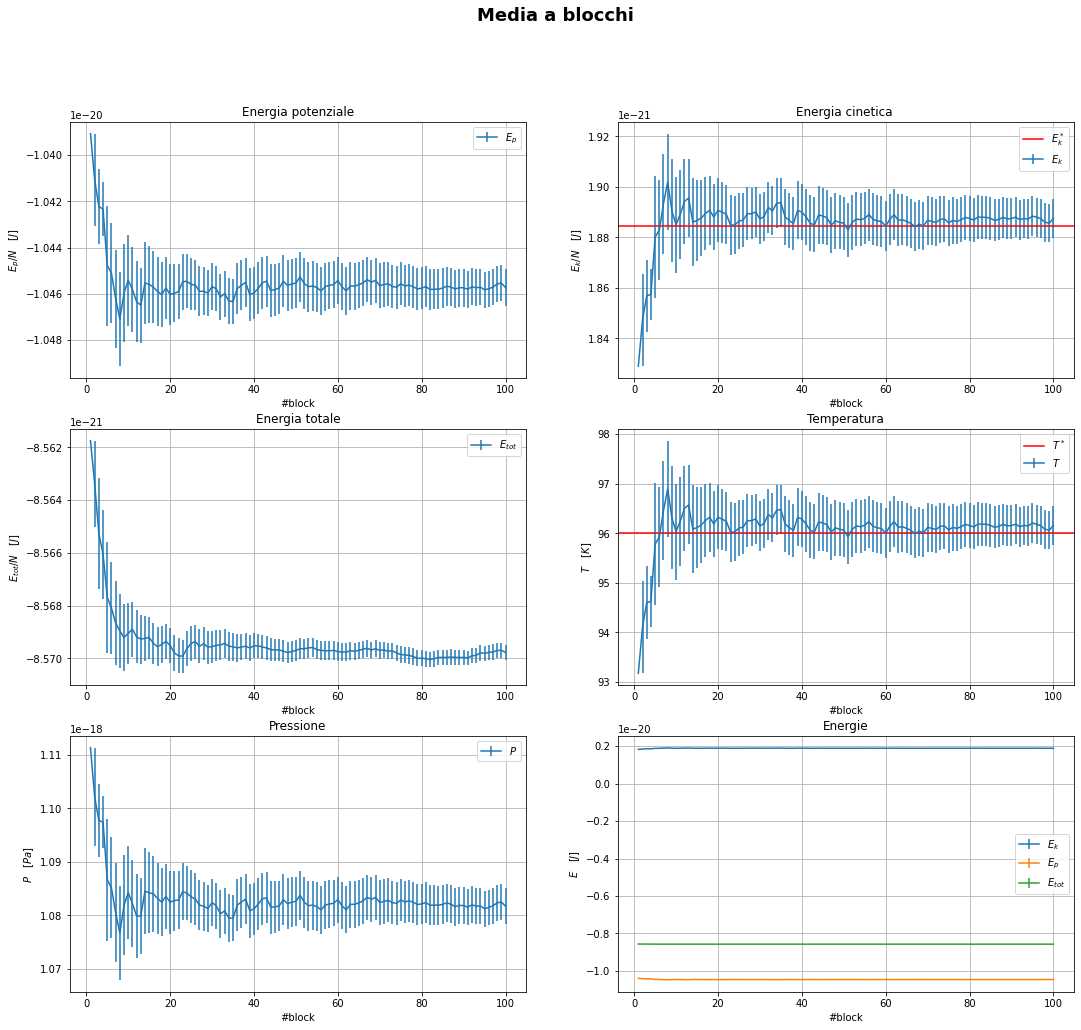

In [27]:
cartella='solid/'
plots(cartella,Temp)

L'energia cinetica risulta effettivamente compatibile con quella teorica. Si osserva inoltre che, correttamente, l'energia cinetica è positiva mentre quella totale è negativa: il sistema è nello stato legato

---------------

# Argon liquido

$T^*=132 K$

Termalizzazione:
- numero di cicli $n_{cicles}=10$
- numero di step per ciclo $n_{step}=250$
- passo temporale $\delta t=0.0006$

Statistica a blocchi:
- numero di blocchi $N_{blocks}=100$
- numero di step per blocco $L=100$

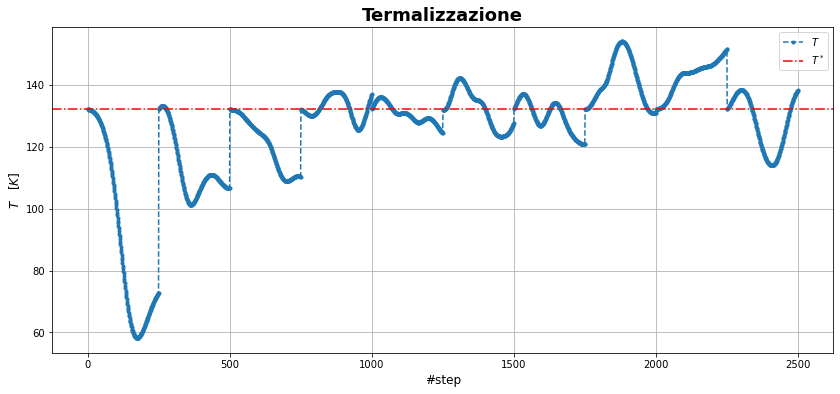

In [30]:
Temp=1.1*(epsi/k_b)

file=open('liquid/output_temp.dat')
T=np.loadtxt(file, delimiter=",", usecols=[0], unpack=True)*(epsi/k_b)
x=np.linspace(0,len(T), len(T))
plt.figure(figsize=(14,6))
plt.title("Termalizzazione", fontsize=18, fontweight='bold')
plt.plot(x, T, '.--', label=r'$T$')
plt.ylabel(f'$T \quad [K]$', fontsize=12)
plt.xlabel('#step', fontsize=12)
plt.axhline(Temp, color='red',ls='-.', label=r'$T^*$')
plt.legend()
plt.grid(True)
plt.show()

Anche in questo caso si osserva come il sistema raggiunge la temperatura desiderata dopo qualche ciclo 

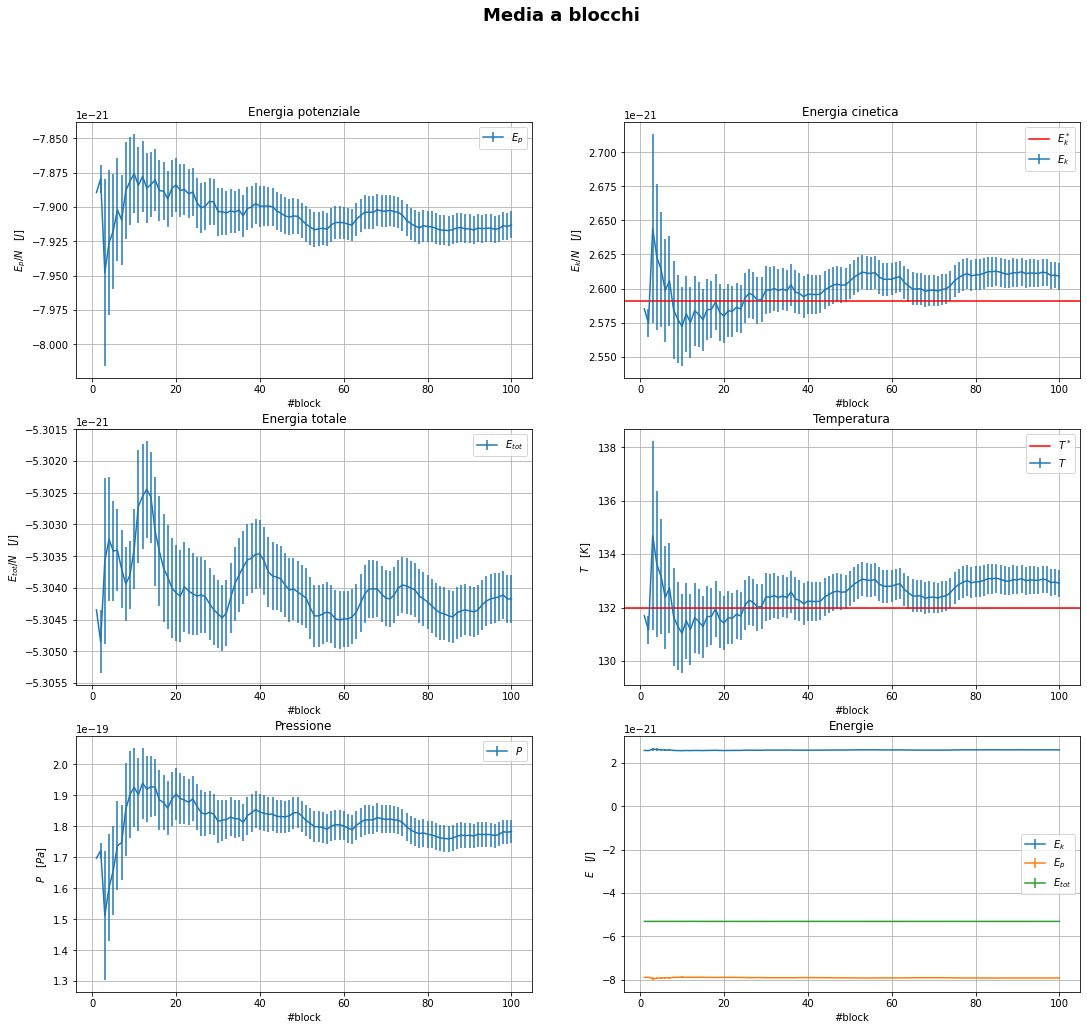

In [31]:
cartella='liquid/'
plots(cartella, Temp)

L'energia calcolata con la media a blocchi non è perfettamente compatibile con quella teorica, ma è vicino ad esserla. L'energia totale è ancora negativa, ma minore (in valore assoluto) rispetto al caso solido

---------------

# Argon Gassoso

$T^*=144 K$

Termalizzazione:
- numero di cicli $n_{cicles}=10$
- numero di step per ciclo $n_{step}=250$
- passo temporale $\delta t=0.0006$

Statistica a blocchi:
- numero di blocchi $N_{blocks}=100$
- numero di step per blocco $L=1000$

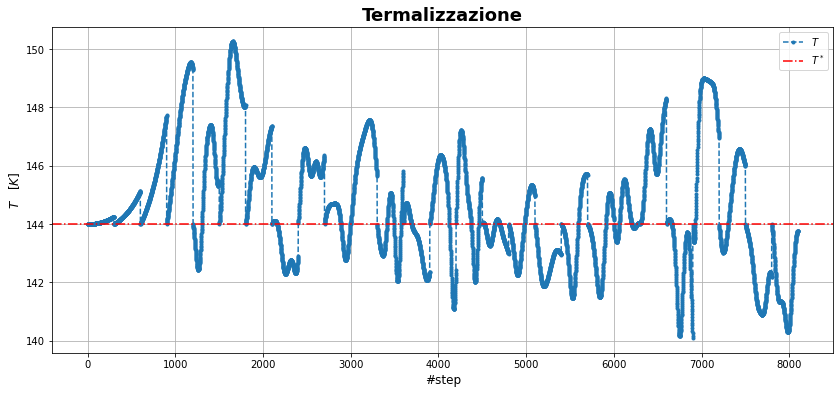

In [32]:
Temp=1.2*(epsi/k_b)

file=open('gas/output_temp.dat')
T=np.loadtxt(file, delimiter=",", usecols=[0], unpack=True)*(epsi/k_b)
x=np.linspace(0,len(T), len(T))

plt.figure(figsize=(14,6))
plt.title("Termalizzazione", fontsize=18, fontweight='bold')
plt.plot(x, T, '.--', label=r'$T$')
plt.ylabel(f'$T \quad [K]$', fontsize=12)
plt.xlabel('#step', fontsize=12)
plt.axhline(Temp, color='red',ls='-.', label=r'$T^*$')
plt.legend()
plt.grid(True)
plt.show()

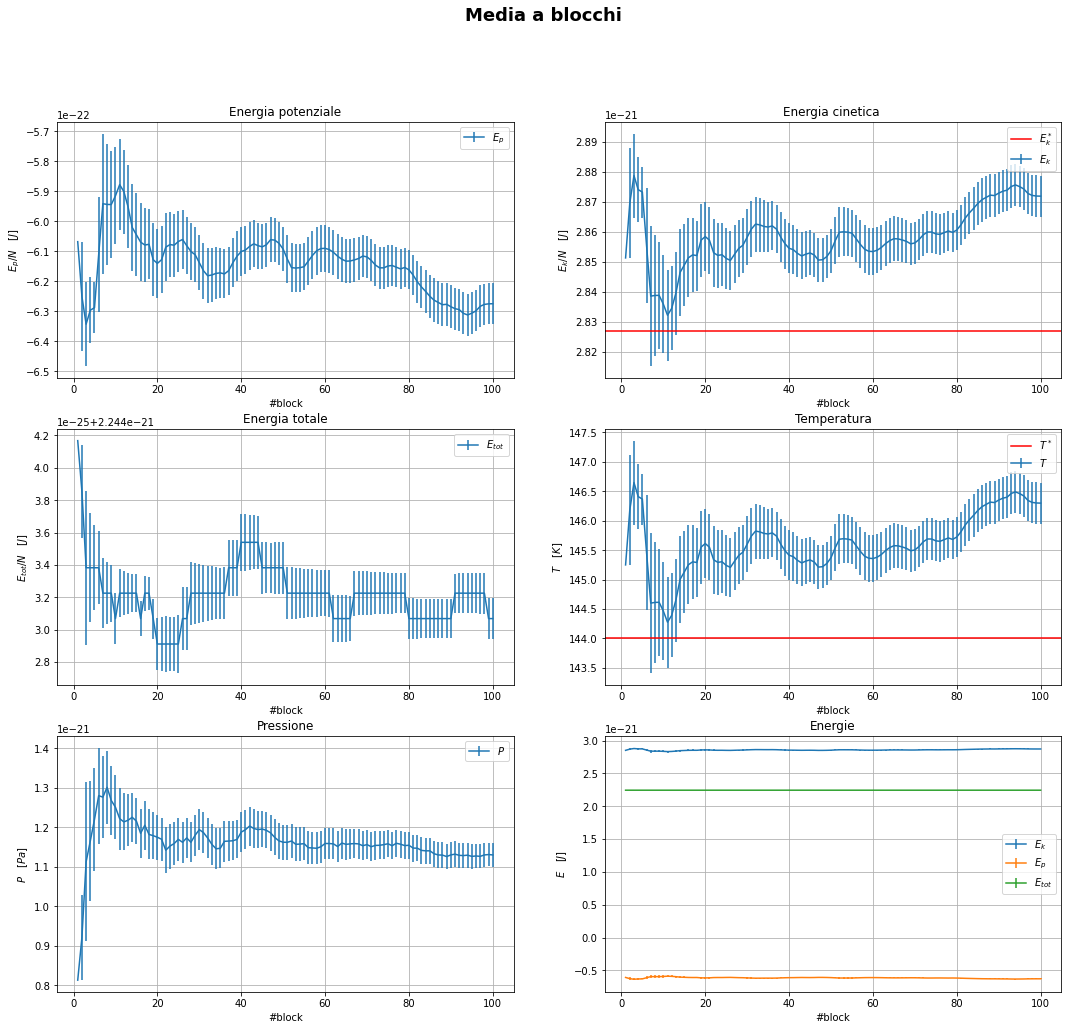

In [33]:
cartella='gas/'
plots(cartella, Temp)

In questo caso risulta particolarmente difficile equilibrare il sistema e probabilmente sarebbe necessario un calcolo computazionale più dispendioso, aumentando il numero di step per blocco, in modo da eliminare il più possibile l'effetto delle fluttuazioni. Nonostante questo è comunque possibile osservare il comportamento corretto del gas: l'energià totale è positiva, quindi le particelle non sono più legate tra loro